In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, lr_scheduler
import torchvision.transforms as T
from torchvision import datasets, ops
from torchvision.models.feature_extraction import create_feature_extractor
from einops import rearrange

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment

In [24]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush', 'empty'
]

# Colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], 
          [0.929, 0.694, 0.125], [0.494, 0.184, 0.556],
          [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
COLORS *= 100


revert_normalization = T.Normalize(
    mean=[-.485/.229, -.456/.224, -.406/.225],
    std=[1/.229, 1/.224, 1/.225]
)


def plot_im_with_boxes(im, boxes, probs=None, ax=None):
    
    if ax is None:
        plt.imshow(im)
        ax = plt.gca()
        
    for i, b in enumerate(boxes.tolist()):
        xmin, ymin, xmax, ymax = b
        
        patch = plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False, color=COLORS[i], linewidth=2)
        
        ax.add_patch(patch)
        if probs is not None:
            if probs.ndim == 1:
                cl = probs[i].item()
                text = f'{CLASSES[cl]}'
            else:
                cl = probs[i].argmax().item()
                text = f'{CLASSES[cl]}: {probs[i,cl]:0.2f}'
        else:
            text = ''
            
        ax.text(xmin + 5, ymin + 12, text, fontsize=7,
                bbox=dict(facecolor='yellow', alpha=0.5))
    
    
def preprocess_target(anno, im_w, im_h):
    
    anno = [obj for obj in anno 
            if 'iscrowd' not in obj or obj['iscrowd'] == 0]

    boxes = [obj["bbox"] for obj in anno]
    boxes = torch.as_tensor(
        boxes, dtype=torch.float32).reshape(-1, 4)
    
    # xywh -> xyxy
    boxes[:, 2:] += boxes[:, :2]
    boxes[:, 0::2].clamp_(min=0, max=im_w)
    boxes[:, 1::2].clamp_(min=0, max=im_h)
    keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
    boxes = boxes[keep]

    classes = [obj["category_id"] for obj in anno]
    classes = torch.tensor(classes, dtype=torch.int64)
    classes = classes[keep]

    # scales boxes to [0,1]
    boxes[:, 0::2] /= im_w
    boxes[:, 1::2] /= im_h
    boxes.clamp_(min=0, max=1)

    boxes = ops.box_convert(boxes, in_fmt='xyxy', out_fmt='cxcywh')
    return classes, boxes


class MyCocoDetection(datasets.CocoDetection):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge = 480

        self.T = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[.485, .456, .406],
                        std=[.229, .224, .225]),
            T.Resize((self.edge, self.edge), antialias=True)
        ])

        self.T_target = preprocess_target

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        # PIL image
        w, h = img.size

        input_ = self.T(img)
        classes, boxes = self.T_target(target, w, h)

        return input_, (classes, boxes)


def collate_fn(inputs):
    input_ = torch.stack([i[0] for i in inputs])
    classes = tuple([i[1][0] for i in inputs])
    boxes = tuple([i[1][1] for i in inputs])
    return input_, (classes, boxes)

In [4]:
train_ds = MyCocoDetection(
    '../datasets/minicoco/train2017',
    '../datasets/minicoco/annotations/instances_minitrain2017.json'
)

train_loader = DataLoader(
    train_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

print(f'\nNumber of training samples: {len(train_ds)}')
# Number of training samples: 50

loading annotations into memory...
Done (t=1.41s)
creating index...
index created!

Number of training samples: 25000


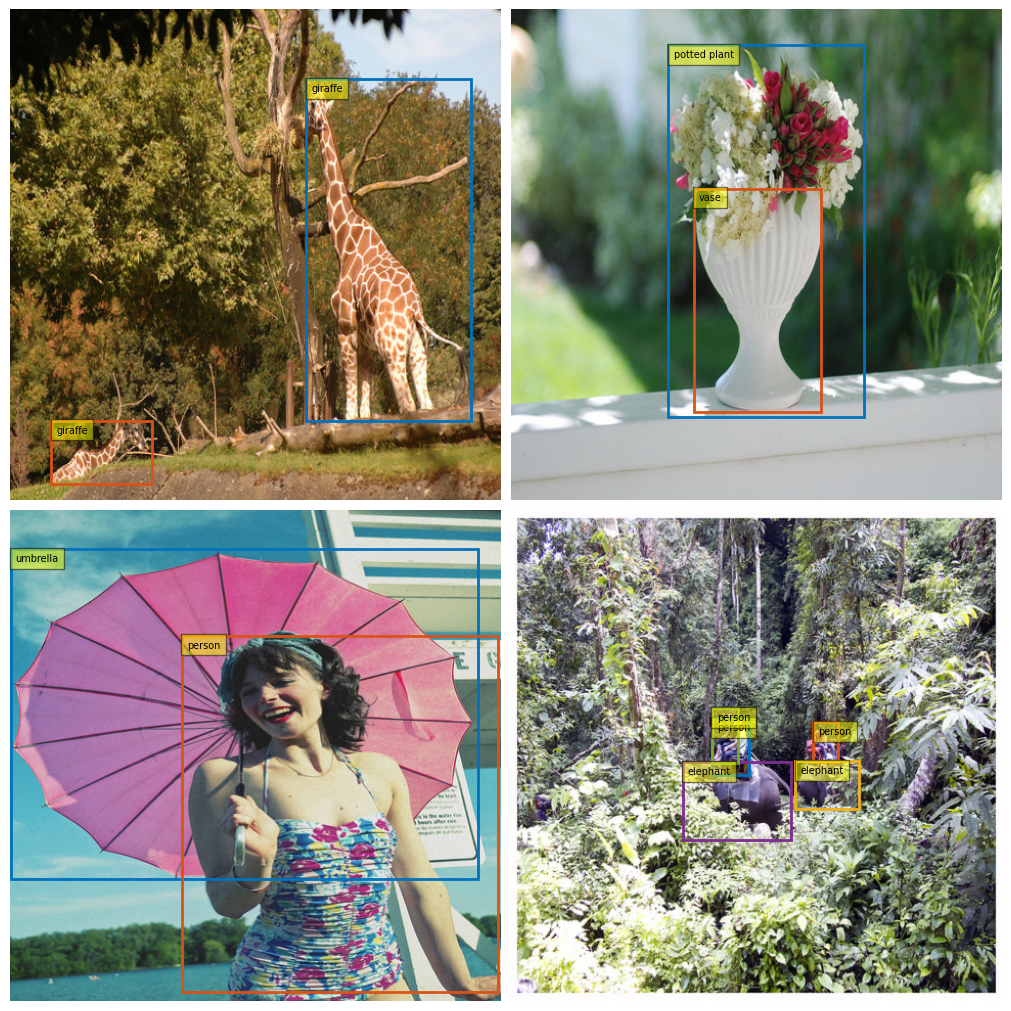

In [25]:
input_, (target) = next(iter(train_loader))
fig = plt.figure(figsize=(10, 10), constrained_layout=True)

for ix in range(4):
    t_cl = target[0][ix].cuda()
    t_bbox = target[1][ix].cuda()

    t_bbox = ops.box_convert(
        t_bbox*480, in_fmt='cxcywh', out_fmt='xyxy')

    im = revert_normalization(input_)[ix].\
        permute(1,2,0).cpu().clip(0,1)

    ax = fig.add_subplot(2, 2, ix+1)
    ax.imshow(im)
    plot_im_with_boxes(im, t_bbox, t_cl, ax=ax)
    ax.set_axis_off()
